# Business Case: Services Demand Forecasting model

This notebook is related to the **Business Case 4 - Services Demand Forecasting**, in the 'Business Cases with Data Science' course, Nova IMS.

April/May - 2020
Project duration: **3 weeks**

All project deliverables were prepared by a team of 4:

* Alexandra Ordina
* Bojan Stavrijk
* Henrique Januário
* Hugo Mentzingen

<div class="alert alert-block alert-info">

The project follows **CRISP-DM process model** and includes the following stages:

* Business understanding
* Data understanding
* Data preparation
* Modeling
* Evaluation
* Deployment

Presentation of the case can be found here: **link to document**
</div>

# Summary

**Client is a private transfer company operating in south of Portugal**

**Business goal:**
Using past booking data develop demand forecast model to predict number of expected services 8 weeks in advance, in order to give the company enough time to hire the drivers. Predictions should be done in 4 weeks batches, with 8 weeks in
advance and should have a maximum deviation of true demand of 10%.

**Data Mining goals and criteria:**
 - Predictive model
 - Performance metrics: **MAPE (Mean absolute percentage error) of model predictions of maximum 10%**
 
**Dataset:**
1. *YFT_Manifesto.csv: main dataset, contains the services contracted in each booking.*
2. *YFT_Customers.csv: dataset with customers details.*
3. *YFT_Luggage.csv: dataset with bookings' luggage details.*

<div class="alert alert-block alert-info">

**Solution:**
Predictive model: **MLP Regressor**
Modelling dataset and input features: we prepared new dataset with aggregated features based on week and year number and created several aggregated features from original raw dataset
</div>

**Dataset description:**

**YFT_Manifesto.csv:**

* bookingID: booking ID
* operatorID: who made the booking (1:YFT, other values:YFT partners)
* whichway: type of service (arrival or departure)
* flightNr: customer's flight number
* paymentType: how customer is going to pay for the service
* customerID: customer ID
* typeOfService: code for type of service. Could be "GOF" for "golf round trip" or 3 letters that mean:
    * 1st letter: type of service purchase (O:One way, R:Return)
    * 2nd letter: Origin (A:Airport, L:Location)
    * 3rd letter: Destination 17 (A:Airport, L:Location)
* serviceDate: date to execute the service
* serviceTime: time to pickup the customer
* pickupLocal: pickup local/region (where the service starts)
* pickupPlaceID: pickup location specific ID
* pickupGPSCoordinates: pickup GPS coordinates
* dropoffLocal: dropoff local/region (where the service ends)
* dropoffPlaceID: dropoff location specific ID
* dropoffGPSCoordinates: dropoff GPS coordinates
* adults: number of adults (13 or more years old)
* children: number of children (3 to 12 years old)
* babies: number of babies (0 to 2 years old)
* vehicleID: ID of the vehicle who did the service (if 0 service not executed or unknown)
* driverID: ID of the driver who did the service (if 0 service not executed or unkown)
* supplierID: ID of the supplier who did the service (0:YFT itself, other values: other partners)
* bookingStatus: current status of the booking
* serviceStatus: current status of the service (a service can be, for example, canceled, but other services in the same booking may continue active)
* bookingDate: date and time when the booking was created.

**YFT_Customers.csv:**

* customerID: customer ID
* countryID: country ID in the format of the international phone dialing code
* subscribeNewsletter: indication if customer subscribed to YFT newsletter (0:No, 1:Yes)
* loyaltyCard: points accumulated on loyalty card
* services: total services provided to the customer so far
* active: indication if customer is still active (0:No, 1:Yes)

**YFT_Luggage.csv:**

* bookingID: booking ID
* whichway: type of service (arrival or departure)
* cargo: type of luggage (checked_luggage, cabin_luggage, others)
* quantity: quantity of this type of cargo
* timer: date and time when YFT become aware of this luggage information


## Libraries and functions

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sb
import scipy
import googlemaps
import warnings
import time
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
from IPython.display import Audio, display
from IPython.display import display_html
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV
warnings.simplefilter('ignore')

In [2]:
#function to play sound after running all iterations of testing
def allDone():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

In [3]:
# Function to display side-by-side different dataframe extractions
def display_side_by_side(args_list):
    html_str=''
    for df in args_list:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [4]:
# Function to convert 'ServiceDate' and 'ServiceTime' variables to a single value in the struct_time format
def service_datetime(service_date, service_time):
    serviceDateTime = service_date + '-' + service_time
    return time.strptime(serviceDateTime, "%Y-%m-%d-%H:%M:%S")

In [5]:
# Function to strip 'pickupGPSCoordinates' and 'dropoffGPSCoordinates' into latitude and longitude.
# Returns latitude, longitude
def strip_gps(GPSCoordinates):
    
    for index, value in GPSCoordinates.iteritems():
        
        if ',' in value:
            
            #remove all spaces
            x = value.replace(' ', '').replace('(','').replace(')','')
            
            #split using the comma as divider
            x = x.split(',')
    
            #convert to float and round in 3 decimal places
            try:
                GPSCoordinates.at[index] = [round(float(i),3) for i in x]
            except:
                GPSCoordinates.at[index] = [0,0]
        
        else:
       
            GPSCoordinates.at[index] = [0,0]
    
    return GPSCoordinates

In [6]:
# Function to calculate the linear distance between two points given their latitudes and longitudes
def calc_dist(vector):
    
    la1 = vector[0] 
    lo1 = vector[1]
    la2 = vector[2]
    lo2 = vector[3]
    
    #radius of the Earth
    R = 6373.0
    #coordinates
    lat1 = math.radians(la1)
    lon1 = math.radians(lo1)
    lat2 = math.radians(la2)
    lon2 = math.radians(lo2)
    #change in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    #Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c

    return distance

In [7]:
# Function to calculate the difference between BookingDate and ServiceDate
def calc_time(df):
    from datetime import datetime,timedelta
    dt=['serviceTime', 'serviceDate', 'bookingDate']
    t=manifesto[df]
    t['serviceDate']=t['serviceDate']+' '+t['serviceTime']
    t.drop('serviceTime',inplace=True,axis=1)
    t['serviceDate'] =  pd.to_datetime(t['serviceDate'], format='%Y-%m-%d %H:%M:%S')
    t['bookingDate'] =  pd.to_datetime(t['bookingDate'], format='%Y-%m-%d %H:%M:%S')
    t['diference']= t['serviceDate']-t['bookingDate']
    indexes = t[t['diference'].dt.days>56].index
    return indexes

In [8]:
# Function to count the number of nulls in each dataset
def count_nulls(df_list):
    nulls_df_list = []
    
    for df in df_list:
        nulls_df_list.append(pd.DataFrame(df.isnull().sum()))
    
    return display_side_by_side(nulls_df_list)    

In [9]:
# Function to plot correlation heatmap
def cor_heatmap(df, method):
    fig, ax = plt.subplots(figsize=(30,30))
    sb.set(font_scale=1.2)
    heat_map = sb.heatmap(df.corr(method = method).round(decimals=2), annot=True, ax=ax, cmap = 'coolwarm')
    plt.show()

In [10]:
# Function to create boxplots
def plt_box(data):
    n_col = 3
    n_row = math.ceil(data[numerical].shape[1]/n_col)
    fig, ax = plt.subplots(n_row, n_col, figsize=(20, 60))
    for var, subplot in zip(data[numerical], ax.flatten()):
        sb.boxplot(data[var], ax=subplot)

In [11]:
#function to remove outliers based on the IQR
def removeOutliers(df, cutoff1, features):
    
    outliers_to_remove = []
    for feature in features:
        if feature in df:
            #calculate interquartile range
            q25, q75 = np.nanpercentile(df[feature], 25), np.nanpercentile(df[feature], 75)
            iqr = q75 - q25
            print(feature)
            print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
        
            #calculate the outlier cutoff
            cut_off = iqr * cutoff1
            lower, upper = q25 - cut_off, q75 + cut_off
        
            #identify outliers
            outliers = [index for index, value in df[feature].iteritems() if value < lower or value > upper]
            print('Identified outliers: %d' % len(outliers))
            outliers_to_remove += outliers
    outliers_to_remove = set(outliers_to_remove)
    outliers_to_remove = sorted(outliers_to_remove)
    return outliers_to_remove

In [12]:
# Function to calculate MAPE performance metric
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest,set1='Train', set2='Test'):
  measures_list = ['MAE','RMSE', 'R^2','MAPE (%)','MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                metricsObj.r2_score(yTrain, yPredTrain),
                mean_absolute_percentage_error(yTrain, yPredTrain),
                metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                metricsObj.r2_score(yTest, yPredTest),
                  mean_absolute_percentage_error(yTest, yPredTest),
                metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, set1: train_results, set2:test_results})
  return(resultsDF)

## 1. Data Loading and Data exploration

**Manifesto** is the main dataset. It contains the services contracted in every booking, including their outcome. One booking can have multiple services associated to it. All other datasets are dimensions that explain the facts of the measures in this dataset. Some of the other datasets contain measures that complement the main dataset and will be used later in feature engineering stage.

In [14]:
# Loading the datasets
# Skipping bad lines 48541,72779,135977,166696
manifesto=pd.read_csv('YFT_Manifesto.csv',sep=';',error_bad_lines=False)
luggage=pd.read_csv('YFT_Luggage.csv',sep=';',error_bad_lines=False)
drivers=pd.read_csv('YFT_Drivers.csv',sep=';',error_bad_lines=False)
customers=pd.read_csv('YFT_Customers.csv',sep=';',error_bad_lines=False)

b'Skipping line 48541: expected 24 fields, saw 25\nSkipping line 51419: expected 24 fields, saw 25\nSkipping line 55106: expected 24 fields, saw 25\nSkipping line 63666: expected 24 fields, saw 25\n'
b'Skipping line 72779: expected 24 fields, saw 25\n'
b'Skipping line 135977: expected 24 fields, saw 25\nSkipping line 141150: expected 24 fields, saw 25\nSkipping line 142906: expected 24 fields, saw 25\nSkipping line 144394: expected 24 fields, saw 25\nSkipping line 144396: expected 24 fields, saw 25\nSkipping line 152122: expected 24 fields, saw 25\n'
b'Skipping line 166696: expected 24 fields, saw 25\n'


In [15]:
# Setting the Pandas option to see all columns
pd.set_option('display.max_columns', None)

In [16]:
# Shape of the main dataset
manifesto.shape

(370264, 24)

In [17]:
manifesto.head(3)

,bookingID,operatorID,whichway,flightNr,paymentType,customerID,typeOfService,serviceDate,serviceTime,pickupLocal,pickupPlaceID,pickupGPSCoordinates,dropoffLocal,dropoffPlaceID,dropoffGPSCoordinates,adults,children,babies,vehicleID,driverID,supplierID,bookingStatus,serviceStatus,bookingDate
0,74968,1,departure,ZB1243,Cash,56823,RAL,2016-01-07,08:15:00,ALBUFEIRA,1,"37.09138973782737, -8.240325450897217",FARO AIRPORT,3,"37.017596,-7.96972",2,0,0,30,29,0,Done,Done,2015-04-07 18:46:08
1,77524,1,departure,FR7033,Cash,24133,RAL,2016-01-12,07:30:00,ALBUFEIRA,1,"37.0884666,-8.22149849",FARO AIRPORT,3,"37.017596,-7.96972",2,0,0,85,163,0,Done,Done,2015-04-29 17:05:44
2,78623,1,departure,EY8918,B.Transfer,25798,RAL,2016-01-02,06:40:00,LAGOS,23,"37.1030579,-8.69011",FARO AIRPORT,3,"37.017596,-7.96972",2,2,0,30,29,0,Done,Done,2015-05-08 12:07:17


In [18]:
# Counting the number of nulls per variable and dataset
count_nulls([manifesto, luggage, drivers, customers])

,0
bookingID,0
operatorID,0
whichway,0
flightNr,20289
paymentType,0
customerID,0
typeOfService,11
serviceDate,0
serviceTime,0
pickupLocal,2


In [19]:
#checking unique values per column
#222814 bookings (means that 147450 duplications exist, in other words bookings contain multiple services)
manifesto.nunique()

bookingID                222814
operatorID                  169
whichway                      2
flightNr                   8573
paymentType                   8
customerID               112669
typeOfService                 7
serviceDate                1432
serviceTime                 863
pickupLocal                 154
pickupPlaceID               151
pickupGPSCoordinates      77413
dropoffLocal                156
dropoffPlaceID              153
dropoffGPSCoordinates     77796
adults                       54
children                     11
babies                        7
vehicleID                   198
driverID                    361
supplierID                   56
bookingStatus                 3
serviceStatus                 3
bookingDate              221590
dtype: int64

## 1.1. Main dataset assessment and preprocessing

In this step we deal with several data issues of our main dataset, such as removing records with null values, cleaning duplicate services, removing impossible values (such as negative count) as data errors. There are some **data quality issues** and at the end of this section there is a summary list of findings and decisions taken based on data exploratory analysis.

### Null values

In [20]:
# Dropping the rows with NaNs, excepting NaNs on 'flightNr'

nulls = manifesto.columns[manifesto.isnull().any()]
nulls = nulls.drop('flightNr')
manifesto.dropna(subset=nulls, inplace=True)
manifesto.reset_index(inplace=True,drop=True)

### Extracting service-level details

Each row in the dataset represents a service. Each service is identified by a bookingID, but a bookingID can have multiple services attached to it; meaning that the dataset doesn’t carry an individual service identifier. Therefore the team created a new feature named serviceID, which uniquely identifies each service in the dataset. This is important because the target variable for prediction is the number of services and not number of bookings.

In [21]:
manifesto['temp_cumcount'] = manifesto.groupby('bookingID').cumcount()
manifesto['serviceID'] = manifesto['bookingID'].astype(str) + manifesto['temp_cumcount'].astype(str)
manifesto['serviceID'] = manifesto['serviceID'].astype(int)
manifesto.drop('temp_cumcount', axis=1, inplace=True)

We have 370264 service lines however some of these might be duplicates and we need to cross-check other fields such as service time, service type, customer id, locations and booking time and make sure they are unique.

In [22]:
manifesto['serviceID'].nunique()

368115

In [23]:
# A sample of a suspicious entry
manifesto[manifesto['bookingID']==157386]

,bookingID,operatorID,whichway,flightNr,paymentType,customerID,typeOfService,serviceDate,serviceTime,pickupLocal,pickupPlaceID,pickupGPSCoordinates,dropoffLocal,dropoffPlaceID,dropoffGPSCoordinates,adults,children,babies,vehicleID,driverID,supplierID,bookingStatus,serviceStatus,bookingDate,serviceID
91914,157386,1,arrival,BA2692,Cash,139197,RAL,2017-02-28,16:10:00,FARO AIRPORT,3,"37.017596,-7.96972",VILAMOURA,2,"37.0910339,-8.093705",2,0,0,149,163,0,Done,Done,2017-02-28 14:33:44,1573860
91915,157386,1,departure,NaN,Cash,139197,RAL,2017-02-28,15:20:00,VILAMOURA,2,"37.0910339,-8.093705",FARO AIRPORT,3,"37.017596,-7.96972",2,0,0,149,163,0,Done,Done,2017-02-28 14:33:44,1573861


### Checking the validity of fields

Due to various errors in the dataset, several rules had to be developed to check validity of the data and clean it. We have cross-checked booking/service status, booking/service date/time and GPS coordinates:

 - inconsistency between status of booking and status of service as shown in below table
 - GPS coordinates outside of area of operation
 - inconsistencies between booking and service date and time

In [24]:
pd.crosstab(index=manifesto['bookingStatus'], columns=manifesto['serviceStatus'])

serviceStatus,Canceled,Done,No-show
bookingStatus,,,
Canceled,636,46584,45
Done,1082,317026,1031
No-show,9,1668,34


### Booking and Service status

##### Rule 1 - Bookings with status Done and all serviceStatus equal to Canceled or No-show

In [25]:
# First we separate only the bookingID with status Done and at least one canceled or no-show service
rule1 = manifesto[(manifesto['bookingStatus']=='Done') & (manifesto['serviceStatus'].isin(['Canceled','No-show']))]['bookingID'].unique()

# Then we test for the existence of at least one 'Done' service.
# If not, the bookingID is included in the badStatus1 list

badStatus1 = []
for i in rule1:
    if 'Done' in manifesto[manifesto['bookingID']==i]['serviceStatus'].unique():
        continue
    else:
        badStatus1.append(i)

print('Bookings with status Done and all serviceStatus equal to Canceled or No-show:', len(badStatus1))

Bookings with status Done and all serviceStatus equal to Canceled or No-show: 819


In [26]:
# Change all these bookings and services to Canceled
manifesto.loc[badStatus1, ['bookingStatus','serviceStatus']] = 'Canceled'

##### Rule 2 - Bookings with status No-show and at least one service with status Done

In [27]:
rule2 = manifesto[(manifesto['bookingStatus']=='No-show') & (manifesto['serviceStatus']=='Done')]['bookingID'].unique()
print('Bookings with status No-show and at least one service with status Done:',len(rule2))

Bookings with status No-show and at least one service with status Done: 991


In [28]:
# Change all these bookings and services to No-show
manifesto.loc[rule2, ['bookingStatus','serviceStatus']] = 'No-show'

##### Rule 3 - Bookings with status No-show and all services with status Canceled

In [29]:
# First we separate only the bookingID with status No-show and at least one canceled service

rule3 = manifesto[(manifesto['bookingStatus']=='No-show') & (manifesto['serviceStatus']=='Canceled')]['bookingID'].unique()

# Then we test for the existence of at least one 'Done' or 'No-show' service
# If not, the bookingID is included in the badStatus3 list

badStatus3 = []
for i in rule3:
    if 'Done' in manifesto[manifesto['bookingID']==i]['serviceStatus'].unique():
        continue
    elif 'No-show' in manifesto[manifesto['bookingID']==i]['serviceStatus'].unique():
        continue
    else:
        badStatus3.append(i)

print('Bookings with status No-show and all services with status Canceled:', len(badStatus3))

Bookings with status No-show and all services with status Canceled: 0


In [30]:
# Change all these bookings and services to No-show
manifesto.loc[badStatus3, ['bookingStatus','serviceStatus']] = 'No-show'

##### Rule 4 - Bookings with status Canceled but with at least one service No-show

In [31]:
rule4 = manifesto[(manifesto['bookingStatus']=='Canceled') & (manifesto['serviceStatus']=='No-show')]['bookingID'].unique()
print('Bookings with status Canceled but with at least one service No-show:', len(rule4))

Bookings with status Canceled but with at least one service No-show: 42


In [32]:
# Change all these bookings and services to Canceled
manifesto.loc[rule4, ['bookingStatus','serviceStatus']] = 'Canceled'

##### Rule 5 - Bookings with status Canceled but with at least one service Done

In [33]:
rule5 = manifesto[(manifesto['bookingStatus']=='Canceled') & (manifesto['serviceStatus']=='Done')]['bookingID'].unique()
print('Bookings with status Canceled but with at least one service Done:', len(rule5))

Bookings with status Canceled but with at least one service Done: 28152


In [34]:
# Change all these bookings and services to Canceled
manifesto.loc[rule5, ['bookingStatus','serviceStatus']] = 'Canceled'

### Booking and Service timings

In [35]:
# Merging ServiceDate and ServiceTime and converting time variables to datetime
# First, we convert 'bookingDate' to the datetime format
manifesto['bookingDate'] = pd.to_datetime(manifesto['bookingDate'])

# Then, we combine 'ServiceDate' and 'ServiceTime' and do the same
manifesto['serviceDate'] = manifesto['serviceDate'] + ' ' + manifesto['serviceTime']
manifesto['serviceDate'] = pd.to_datetime(manifesto['serviceDate'])
manifesto.drop(columns='serviceTime',inplace=True)

In [36]:
# Checking whether the booking occurs after the service has been performed
# exclude these rows

manifesto.reset_index(inplace=True, drop=True)
manifesto = manifesto[~(manifesto['serviceDate']<manifesto['bookingDate'])]

### GPS coordinates

GPS coordinates have been validated based on whether they are inside Portugal/Spain and pickup/dropoff coordinates are more distant than 500 meters

In [37]:
# Create four variables to represent the pickup and dropoff GPS coordinates (separately)
manifesto.reset_index(inplace=True, drop=True)

# Clean the coordinates, split the values from a string to a list with two numeric values
temp_GPS = strip_gps(manifesto['pickupGPSCoordinates'])

# creating the variables
manifesto['pickupLat'] = pd.DataFrame(temp_GPS.values.tolist())[0]
manifesto['pickupLon'] = pd.DataFrame(temp_GPS.values.tolist())[1]

# cleaning the rows that had strings other than coordinates (eg. 'Infante Sagres, 117, Quarteira, Algarve')
# these strings were transformed to [0,0] coordinates, now we need to remove these rows
manifesto = manifesto[~((manifesto['pickupLat']==0) | (manifesto['pickupLon']==0))]
manifesto.reset_index(inplace=True, drop=True)

# Clean the coordinates, split the values from a string to a list with two numeric values
temp_GPS = strip_gps(manifesto['dropoffGPSCoordinates'])

# creating the variables
manifesto['dropoffLat'] = pd.DataFrame(temp_GPS.values.tolist())[0]
manifesto['dropoffLon'] = pd.DataFrame(temp_GPS.values.tolist())[1]

# cleaning the rows that had strings other than coordinates (eg. 'Infante Sagres, 117, Quarteira, Algarve')
# these strings were transformed to [0,0] coordinates, now we need to remove these rows
manifesto = manifesto[~((manifesto['dropoffLat']==0) | (manifesto['dropoffLon']==0))]
manifesto.reset_index(inplace=True, drop=True)

# Dropping the remaining NaNs
manifesto.dropna(subset=['pickupLat','pickupLon','dropoffLat','dropoffLon'], inplace=True)

In [38]:
# Checking if the GPS coordinates are located inside Portugal + Spain borders
spain_north_lat = 43.72413
spain_east_lon = 3.27487
spain_south_lat = 36.06695
portugal_west_lon = -9.55716

manifesto = manifesto[((manifesto['pickupLat']>=spain_south_lat) &
                       (manifesto['pickupLat']<=spain_north_lat) &
                       (manifesto['dropoffLat']>=spain_south_lat) &
                       (manifesto['dropoffLat']<=spain_north_lat) &
                       (manifesto['pickupLon']>=portugal_west_lon) &
                       (manifesto['pickupLon']<=spain_east_lon) &
                       (manifesto['dropoffLon']>=portugal_west_lon) &
                       (manifesto['dropoffLon']<=spain_east_lon))]

manifesto.reset_index(inplace=True, drop=True)

### Cleaning data errors
Dropping services with negative count of babies and children and services without adults (services cannot be booked by a child)

In [39]:
#5 records with negative count of kids
neg=['children', 'babies']
manifesto[neg].where(manifesto[neg] < 0).count()

children    3
babies      2
dtype: int64

In [40]:
#19 records with no adult in service line
manifesto['adults'].where(manifesto['adults'] < 1).count()

19

In [41]:
#dropping those 
manifesto = manifesto[((manifesto['adults']>=1) &
                       (manifesto['children']>=0) &
                       (manifesto['babies']>=0)
                      )]

manifesto.reset_index(inplace=True, drop=True)

### Dropping duplicated services

Criteria: checking if two services are performed in the same day, with the same 'bookingID', same transfer type and driver but service time being different for at most 1h. In this case, we consider that the second service is just a booking change drop the second service.

In [42]:
delta = timedelta(hours=1)
manifesto.sort_values(by='serviceDate', ascending=True, inplace=True)

# Checking how many rows satisfy this condition
# diff function is used to compare each row with it's antecedent
print('# of rows that satisfy this condition:',
      manifesto[((manifesto['serviceDate'].diff()<delta) & (manifesto['bookingID'].diff()==0))].shape[0])

# Dropping the rows by this condition
manifesto = manifesto[~((manifesto['serviceDate'].diff()<delta) & (manifesto['bookingID'].diff()==0))]
manifesto.reset_index(inplace=True, drop=True)

# Dropping the rows which represent duplicates taking into consideration 'bookingID', 'whichway' and 'driverID'
print('# of rows in the manifesto dataset BEFORE dropping the duplicates:',
      manifesto.shape[0])
manifesto.drop_duplicates(subset=['bookingID','whichway','driverID'],inplace=True)

print('# of rows in the manifesto dataset AFTER dropping the duplicates:',
      manifesto.shape[0])

# of rows that satisfy this condition: 2668
# of rows in the manifesto dataset BEFORE dropping the duplicates: 358032
# of rows in the manifesto dataset AFTER dropping the duplicates: 357480


<div class="alert alert-block alert-info">


### Data exploration and pre-procesing summary insights and conclusions

* We are in data-rich situation so are dropping records with null values in all columns except FlightN (22K is around 6%).
        
* Data granularity for the forecasting is number of services, which are not equivalent to number of bookings, so we are creating a new feature "ServiceID" and as we will be training model on weekly predictions, create a feature with the week number to be able to perform aggregations on independent features and also on the target "weekly total number of services".

* After identifying service level details, it appeared that there are bookings with services count equal to zero as there are null values in typeOfService which will be dropped.

* Data errors were identified and cleaned: Negative values in count of passengers, services without adult passengers, negative values in leadtime (these errors represent minor percentage of full dataset)

* Inconsistencies and anomalies in data are corrected based on discussion with client (e.g. duplicate values, timing difference in services, status of bookings vs status os services within each booking, transfers below minimal threshold of transfer length)

</div>


# 2. Feature engineering

The features that we deem important which reflect some patterns of clients' booking behaviour:
    * Lead time (in days and weeks)
    * Distance travelled while performing the service
    * Airline (low-cost or regular)
    * 8 weeks lead (Y/N)

In [43]:
# We calculate the time interval between these two datetime values
manifesto['leadtimeDays'] = (manifesto['serviceDate'] - manifesto['bookingDate']).dt.days
manifesto['leadtimeWeeks'] = round(manifesto['leadtimeDays']/7,2)

In [44]:
# checking for negative values that might be problematic
neg = ['leadtimeWeeks','leadtimeDays']
manifesto[neg].where(manifesto[neg] < 0).count()

leadtimeWeeks    0
leadtimeDays     0
dtype: int64

In [45]:
# Create a variable to represent the distance traveled in each service based on GPS coordinates
manifesto['serviceDistance'] = manifesto[['pickupLat','pickupLon','dropoffLat','dropoffLon']].apply(calc_dist, axis=1)

In [46]:
# Again, we check for nulls in all variables
nulls = manifesto.columns[manifesto.isnull().any()]
manifesto[nulls].isnull().sum()

flightNr    18855
dtype: int64

In [47]:
#sorting by descending distance
manifesto.sort_values(by='serviceDistance', ascending=False,inplace=True)

# Services where the distance is lower than 500m, may represent wrong entries in the GPS Coordinates
manifesto[manifesto['serviceDistance']<0.5].shape

(1610, 31)

In [48]:
# We'll drop these rows
manifesto = manifesto[~(manifesto['serviceDistance']<0.5)]
manifesto.reset_index(inplace=True, drop=True)

#### Extracting airline information from flightNr variable

In [49]:
# Creating a variable 'airline' which represents the airline associated with each booking
manifesto['airline'] = manifesto['flightNr'].str.replace(r'\d+', '').str.lower()
manifesto['airline'] = manifesto['airline'].fillna('other')
manifesto['airline'] = manifesto['airline'].apply(lambda x: 'other' if x.strip()=='' else x)  
manifesto['airline'] = manifesto['airline'].str.strip(" ")

# Manually dealing with the most frequent cases
manifesto['airline'] = manifesto['airline'].str.replace('frfr','fr')
manifesto['airline'] = manifesto['airline'].str.replace('ezyezy','ezy')
manifesto['airline'] = manifesto['airline'].str.replace('eiei','ei')
manifesto['airline'] = manifesto['airline'].str.replace('lsls','ls')
airlineCounts = manifesto['airline'].value_counts()

# Dealing with the very sparse occurrences of airlines and mistypings
# Setting the airline to 'other' when the number of ocurrences for that airline is lower than 2.000

manifesto['airline'] = manifesto['airline'].apply(lambda x: 'other' if airlineCounts[x]<2000 else x)
manifesto[['airline','bookingID']].groupby('airline').count().sort_values(by='bookingID',ascending=False)

,bookingID
airline,
fr,123888
ezy,73858
ei,47079
other,42015
ls,31904
zb,12773
ba,9452
tp,4442
be,4313


In [50]:
# Creating a variable to set wheter the airline is low cost
lowCostDict = {'fr': 1, #RyanAir
               'ezy': 1, #Easyjet
               'ei': 1, #AerLingus
               'other': 0,
               'ls': 1, #Jet2
               'zb': 0, #AirAlbania
               'ba': 0, #BritishAirways
               'tp': 0, #TAP
               'be': 1, #Flybe
               'hv': 1, #Transavia
               'tom': 1, #TUI
}

manifesto['lowCostAir'] = manifesto['airline'].apply(lambda x: lowCostDict[x])

In [51]:
# Creating a variable '8WeeksLead' to set wheter the service was booked 8 weeks before (binary 1 = 8 weeks or earlier, 0 = later)
delta = timedelta(weeks=8)
manifesto['8WeeksLead'] = manifesto.apply(lambda x: 1 if (x.serviceDate - x.bookingDate >= delta) else 0, axis=1)

# 3. Creating Modeling dataset with Aggregated Features

Due to the specific constraint given by the client, the team needed to perform clever aggregation of the data. 
The following steps were done in order to achieve this:
1.	Services with **'serviceStatus' Done** were selected
2.	A table with **total number of services** by year and week number was generated taking only services booked with minimum 8 week lead time
3.	**Aggregated features** were computed and added to this table

<div class="alert alert-block alert-info">

At the end of this step we had our modelling dataset **'modelling_df'** to be used for training and testing the model, showing data based on year and week number
</div>


### 3.1. Creating modeling dataset

In [52]:
#Create a copy of main dataframe which will be transformed to modeling dataset. Add columns for week number and year.
aggregate_df= manifesto.copy(deep=True)
aggregate_df['year'] = aggregate_df['serviceDate'].dt.year.map(str)
aggregate_df['week'] = aggregate_df['serviceDate'].dt.week.map(str)

In [53]:
aggregate_df.columns

Index(['bookingID', 'operatorID', 'whichway', 'flightNr', 'paymentType',
       'customerID', 'typeOfService', 'serviceDate', 'pickupLocal',
       'pickupPlaceID', 'pickupGPSCoordinates', 'dropoffLocal',
       'dropoffPlaceID', 'dropoffGPSCoordinates', 'adults', 'children',
       'babies', 'vehicleID', 'driverID', 'supplierID', 'bookingStatus',
       'serviceStatus', 'bookingDate', 'serviceID', 'pickupLat', 'pickupLon',
       'dropoffLat', 'dropoffLon', 'leadtimeDays', 'leadtimeWeeks',
       'serviceDistance', 'airline', 'lowCostAir', '8WeeksLead', 'year',
       'week'],
      dtype='object')

In [54]:
# Reordering the dataframe and dropping the unnecessary columns
cols = ['year', 'week', 'whichway', 'customerID', 'paymentType',
       'typeOfService', 'serviceDate', 'adults', 'children',
       'babies', 'vehicleID', 'driverID', 'bookingStatus',
       'serviceStatus', 'bookingDate', 'leadtimeDays', 'serviceDistance',
       'airline','lowCostAir','8WeeksLead']
aggregate_df = aggregate_df[cols]

<div class="alert alert-block alert-info">

The **aggregate_df_done** is a slice of main dataset filtered by service status 'Done'. It contains only the data for the real demand.
</div>

In [55]:
# Create a dataframe only with bookings/services not canceled or no-show (real demand)
aggregate_df_done = aggregate_df[(aggregate_df['bookingStatus']=='Done') & (aggregate_df['serviceStatus']=='Done')]
print ('# of rows BEFORE filtering bookings and services:', aggregate_df.shape[0])
print ('# of rows AFTER filtering bookings and services:', aggregate_df_done.shape[0])

# of rows BEFORE filtering bookings and services: 355870
# of rows AFTER filtering bookings and services: 282193


<div class="alert alert-block alert-info">
    
The **modelling_df** is aggregate_df_done dataframe aggregated by year and week and filtered to include only services booked 8 or more weeks in advance. This is crucial as in production environment to make predictions 8 weeks in advance we can only use the data available at the moment when prediction is made or earlier.

</div>

In [56]:
# Create a dataframe with totals services per week (target) - Only with bookings/services not canceled or no-show
modeling_df = aggregate_df_done.groupby(by=['year','week']).size().reset_index(name='services')

In [57]:
n_rows = aggregate_df_done.shape[0]
aggregate_df_done = aggregate_df_done[aggregate_df_done['8WeeksLead']==1]
aggregate_df_done.reset_index(inplace=True,drop=True)

### 3.2. Computing aggregated features

#### Columns transformed into ratios:
*  whichway

#### Columns transformed to sum:
* 'adults'
* 'children'
* 'babies'
* 'leadtimeDays'
* 'serviceDistance'
* '8WeeksLead'
*  'PaymentType'
*  'TypeOfService'

#### Columns transformed to count unique:
* 'driverID' - number of unique drivers per week
* 'vehicleID' - number of unique vehicles per week
* 'customerID' - number of unique customers per week#### Columns transformed into ratios:
*  whichway


#### Features from main dataset:

In [58]:
# Get the sum of adults per week for arrivals/departures
paxPerWeek = aggregate_df_done.pivot_table(values='adults' ,index=['year','week'], columns='whichway', aggfunc=np.sum).fillna(0)
paxPerWeek.reset_index(inplace=True)
paxPerWeek = paxPerWeek.rename(columns={'arrival':'AdultsArr','departure':'AdultsDep'})

# Merge these values with the modelling dataset
modeling_df = modeling_df.merge(right=paxPerWeek, how='left', on=['year','week'])

# Get the sum of children per week for arrivals/departures
paxPerWeek = aggregate_df_done.pivot_table(values='children' ,index=['year','week'], columns='whichway', aggfunc=np.sum).fillna(0)
paxPerWeek.reset_index(inplace=True)
paxPerWeek = paxPerWeek.rename(columns={'arrival':'ChildrenArr','departure':'ChildrenDep'})

# Merge these values with the modelling dataset
modeling_df = modeling_df.merge(right=paxPerWeek, how='left', on=['year','week'])

# Get the sum of babies per week arrivals/departures
paxPerWeek = aggregate_df_done.pivot_table(values='babies' ,index=['year','week'], columns='whichway', aggfunc=np.sum).fillna(0)
paxPerWeek.reset_index(inplace=True)
paxPerWeek = paxPerWeek.rename(columns={'arrival':'BabiesArr','departure':'BabiesDep'})

# Merge these values with the modelling dataset
modeling_df = modeling_df.merge(right=paxPerWeek, how='left', on=['year','week'])


# Get the sum of serviceDistance per week for arrivals/departures
distancePerWeek = aggregate_df_done.pivot_table(values='serviceDistance' ,index=['year','week'], columns='whichway', aggfunc=np.sum).fillna(0)
distancePerWeek.reset_index(inplace=True)
distancePerWeek = distancePerWeek.rename(columns={'arrival':'DistArr','departure':'DistDep'})

# Merge these values with the modelling dataset
modeling_df = modeling_df.merge(right=distancePerWeek, how='left', on=['year','week'])

# Get the sum of 8WeeksLead per week and for arrivals/departures
WeeksLeadPerWeek = aggregate_df_done.pivot_table(values='8WeeksLead' ,index=['year','week'], columns='whichway', aggfunc=np.sum).fillna(0)
WeeksLeadPerWeek.reset_index(inplace=True)
WeeksLeadPerWeek = WeeksLeadPerWeek.rename(columns={'arrival':'WeeksLeadArr','departure':'WeeksLeadDep'})

# Merge these values with the modelling dataset
modeling_df = modeling_df.merge(right=WeeksLeadPerWeek, how='left', on=['year','week'])

# Get the sum of lowCostAir per week for arrivals/departures
lowCostAirPerWeek = aggregate_df_done.pivot_table(values='lowCostAir' ,index=['year','week'], columns='whichway', aggfunc=np.sum).fillna(0)
lowCostAirPerWeek.reset_index(inplace=True)
lowCostAirPerWeek = lowCostAirPerWeek.rename(columns={'arrival':'lowCostAirArr','departure':'lowCostAirDep'})

# Merge these values with the modelling dataset
modeling_df = modeling_df.merge(right=lowCostAirPerWeek, how='left', on=['year','week'])

# Get the average leadTimeDays per week for arrivals/departures
leadtimePerWeek = aggregate_df_done.pivot_table(values='leadtimeDays' ,index=['year','week'], columns='whichway', aggfunc=np.mean).fillna(0)
leadtimePerWeek.reset_index(inplace=True)
leadtimePerWeek = leadtimePerWeek.rename(columns={'arrival':'avgLeadArr','departure':'avgLeadDep'})

# Merge these values with the modelling dataset
modeling_df = modeling_df.merge(right=leadtimePerWeek, how='left', on=['year','week'])

# Get the number of unique Drivers per week
uniqueDriversPerWeek = aggregate_df_done.pivot_table(values='driverID' ,index=['year','week'], aggfunc=pd.Series.nunique).fillna(0)
uniqueDriversPerWeek.reset_index(inplace=True)
uniqueDriversPerWeek = uniqueDriversPerWeek.rename(columns={'driverID':'drivers'})

# Merge these values with the modelling dataset
modeling_df = modeling_df.merge(right=uniqueDriversPerWeek, how='left', on=['year','week'])

# Get the number of unique Vehicles per week
uniqueVehiclesPerWeek = aggregate_df_done.pivot_table(values='vehicleID' ,index=['year','week'], aggfunc=pd.Series.nunique).fillna(0)
uniqueVehiclesPerWeek.reset_index(inplace=True)
uniqueVehiclesPerWeek = uniqueVehiclesPerWeek.rename(columns={'vehicleID':'vehicles'})

# Merge these values with the modelling dataset
modeling_df = modeling_df.merge(right=uniqueVehiclesPerWeek, how='left', on=['year','week'])

# Get the number of unique Customers per week
uniqueCustomersPerWeek = aggregate_df_done.pivot_table(values='customerID' ,index=['year','week'], aggfunc=pd.Series.nunique).fillna(0)
uniqueCustomersPerWeek.reset_index(inplace=True)
uniqueCustomersPerWeek = uniqueCustomersPerWeek.rename(columns={'customerID':'customers'})

# Merge these values with the modelling dataset
modeling_df = modeling_df.merge(right=uniqueCustomersPerWeek, how='left', on=['year','week'])

# Get the whichway/services sum per week
whichwaySumPerWeek = aggregate_df_done.groupby(by=['year','week','whichway']).size().reset_index(name='services')
whichwaySumPerWeek = whichwaySumPerWeek.pivot_table(values='services', columns='whichway',index=['year','week'], aggfunc=np.sum).fillna(0)
whichwaySumPerWeek.reset_index(inplace=True)
whichwaySumPerWeek = whichwaySumPerWeek.rename(columns={'arrival':'arrivalsSum', 'departure':'departuresSum'})

# Merge these values with the modelling dataset
modeling_df = modeling_df.merge(right=whichwaySumPerWeek, how='left', on=['year','week'])

#Get the paymentType/services sum per week and paymentType
paymentTypeSumPerWeek = aggregate_df_done.groupby(by=['year','week','paymentType']).size().reset_index(name='services')
paymentTypeSumPerWeek = paymentTypeSumPerWeek.pivot_table(values='services', columns='paymentType',index=['year','week'], aggfunc=np.sum).fillna(0)
paymentTypeSumPerWeek.reset_index(inplace=True)
paymentTypeSumPerWeek = paymentTypeSumPerWeek.rename(columns={'Cash':'cashSum',
                                                                  'C.Card':'cCardSum',
                                                                  'B.Transfer':'bTransferSum',
                                                                  'Op.Collected':'opCollSum',
                                                                  'PayPal':'paypalSum',
                                                                  'B.Transfer+Cash':'transfer+cashSum',
                                                                  'C.Card+Cash':'card+cashSum',
                                                                  'Other':'otherPaySum'
                                                                 })

# Merge these values with the modelling dataset
modeling_df = modeling_df.merge(right=paymentTypeSumPerWeek, how='left', on=['year','week'])

# Checking the unique types of service
aggregate_df_done['typeOfService'].unique()

# Get the typeOfService/services sum per week and service type
typeOfServiceSumPerWeek = aggregate_df_done.groupby(by=['year','week','typeOfService']).size().reset_index(name='services')
typeOfServiceSumPerWeek = typeOfServiceSumPerWeek.pivot_table(values='services', columns='typeOfService',index=['year','week'], aggfunc=np.sum).fillna(0)
typeOfServiceSumPerWeek.reset_index(inplace=True)
typeOfServiceSumPerWeek = typeOfServiceSumPerWeek.rename(columns={'RAL':'ralSum',
                                                                  'OLA':'olaSum',
                                                                  'OAL':'oalSum',
                                                                  'OLL':'ollSum',
                                                                  'RLL':'rllSum',
                                                                  'GOF':'gofSum',
                                                                  'RLA':'rlaSum'
                                                                 })

# Merge these values with the modelling dataset
modeling_df = modeling_df.merge(right=typeOfServiceSumPerWeek, how='left', on=['year','week'])

#### Bringing features from clients dataset:

In [59]:
#Get frequent customers from customers file and create a binary column in aggregate_df_done
frequent = customers[customers['services']>=10]['customerID']
aggregate_df_done['frequent'] = aggregate_df_done['customerID'].isin(frequent)

# Get the sum of services per week booked by frequent clients
frequentSumPerWeek = aggregate_df_done.groupby(by=['year','week','frequent']).size().reset_index(name='freq')
frequentSumPerWeek = frequentSumPerWeek.pivot_table(values='freq', columns='frequent',index=['year','week'], aggfunc=np.sum).fillna(0)
frequentSumPerWeek.reset_index(inplace=True)
frequentSumPerWeek = frequentSumPerWeek.rename(columns={False:'FreqFalseSum', True:'FreqTrueSum'})
frequentSumPerWeek.drop('FreqFalseSum',inplace=True,axis=1)

# Merge these values with the modelling dataset
modeling_df = modeling_df.merge(right=frequentSumPerWeek, how='left', on=['year','week'])

<div class="alert alert-block alert-info">
    
**The following code until the end of this section is dedicated to exploring unusual time patterns to be aware of in order to get accurate forecasting:**

</div>

In [61]:
#calculate yearly variances per week to explore the services trend over time and find weeks off pattern
modeling_df['week'] = modeling_df['week'].astype(int)
variance = modeling_df.pivot(index='week', columns='year', values='services')
variance.columns = ['2016','2017','2018','2019']
variance.index.name = None
variance[' variance 2017-16'] = variance['2017']-variance['2016']
variance[' variance 2018-17'] = variance['2018']-variance['2017']
variance[' variance 2019-18'] = variance['2019']-variance['2018']
#variance.to_csv('variance.csv',index=True)

In [62]:
#2019 year shows very large variance, with a large drop in services and large increase
variance.describe()

,2016,2017,2018,2019,variance 2017-16,variance 2018-17,variance 2019-18
count,53.000000,52.000000,52.000000,49.000000,52.000000,52.000000,49.000000
mean,1281.283019,1339.288462,1313.192308,1558.285714,35.769231,-26.096154,186.122449
std,882.942771,873.869002,883.357766,1038.205784,183.252062,249.968881,525.862967
min,125.000000,176.000000,199.000000,30.000000,-313.000000,-485.000000,-1415.000000
25%,362.000000,409.250000,355.000000,552.000000,-114.000000,-183.250000,1.000000
50%,1199.000000,1521.500000,1342.500000,1537.000000,33.000000,-69.500000,213.000000
75%,2218.000000,2242.500000,2184.750000,2748.000000,165.500000,134.250000,478.000000
max,2446.000000,2399.000000,2692.000000,2996.000000,528.000000,502.000000,1178.000000


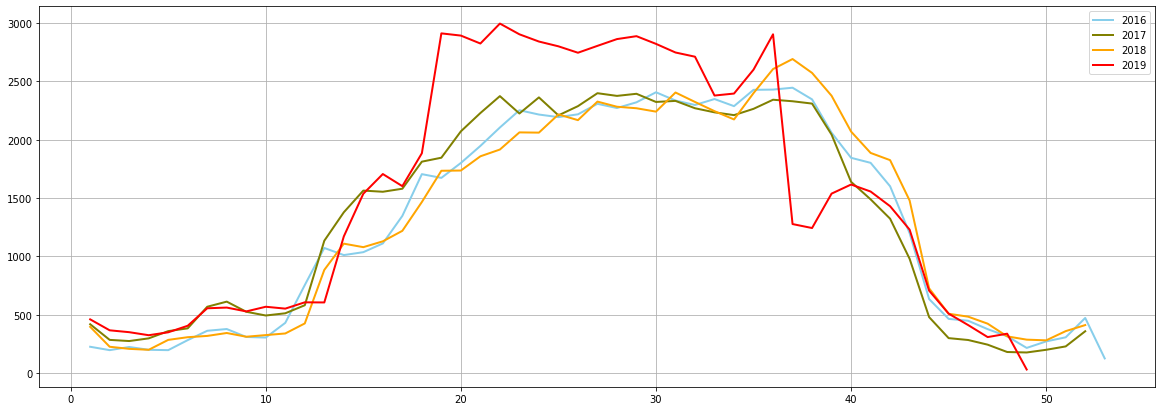

In [63]:
# Plot count of services time series
plt.figure(figsize=(20,7))
plt.plot( variance['2016'], marker='', color='skyblue', linewidth=2,label='2016')
plt.plot( variance['2017'], marker='', color='olive', linewidth=2,label='2017')
plt.plot( variance['2018'], marker='', color='orange', linewidth=2,label='2018')
plt.plot( variance['2019'], marker='', color='red', linewidth=2,label='2019')
plt.grid(which='both')
plt.legend()

In [65]:
# Creating two variables to mark Brexit and Thomas Cook bankruptcy periods
# Brexit : 'brexit' : weeks 19-22, 2019
# Thomas Cook : 'thomasCook' : weeks 37-40, 2019
modeling_df['brexit'] = modeling_df.apply(lambda x: 1 if ((19 <= x.week <= 22) & (x.year=='2019')) else 0, axis=1)
modeling_df['thomasCook'] = modeling_df.apply(lambda x: 1 if ((37 <= x.week <= 40) & (x.year=='2019')) else 0, axis=1)

# 4. Feature selection

In [68]:
# Current shape of modelling_df
modeling_df.shape

(206, 40)

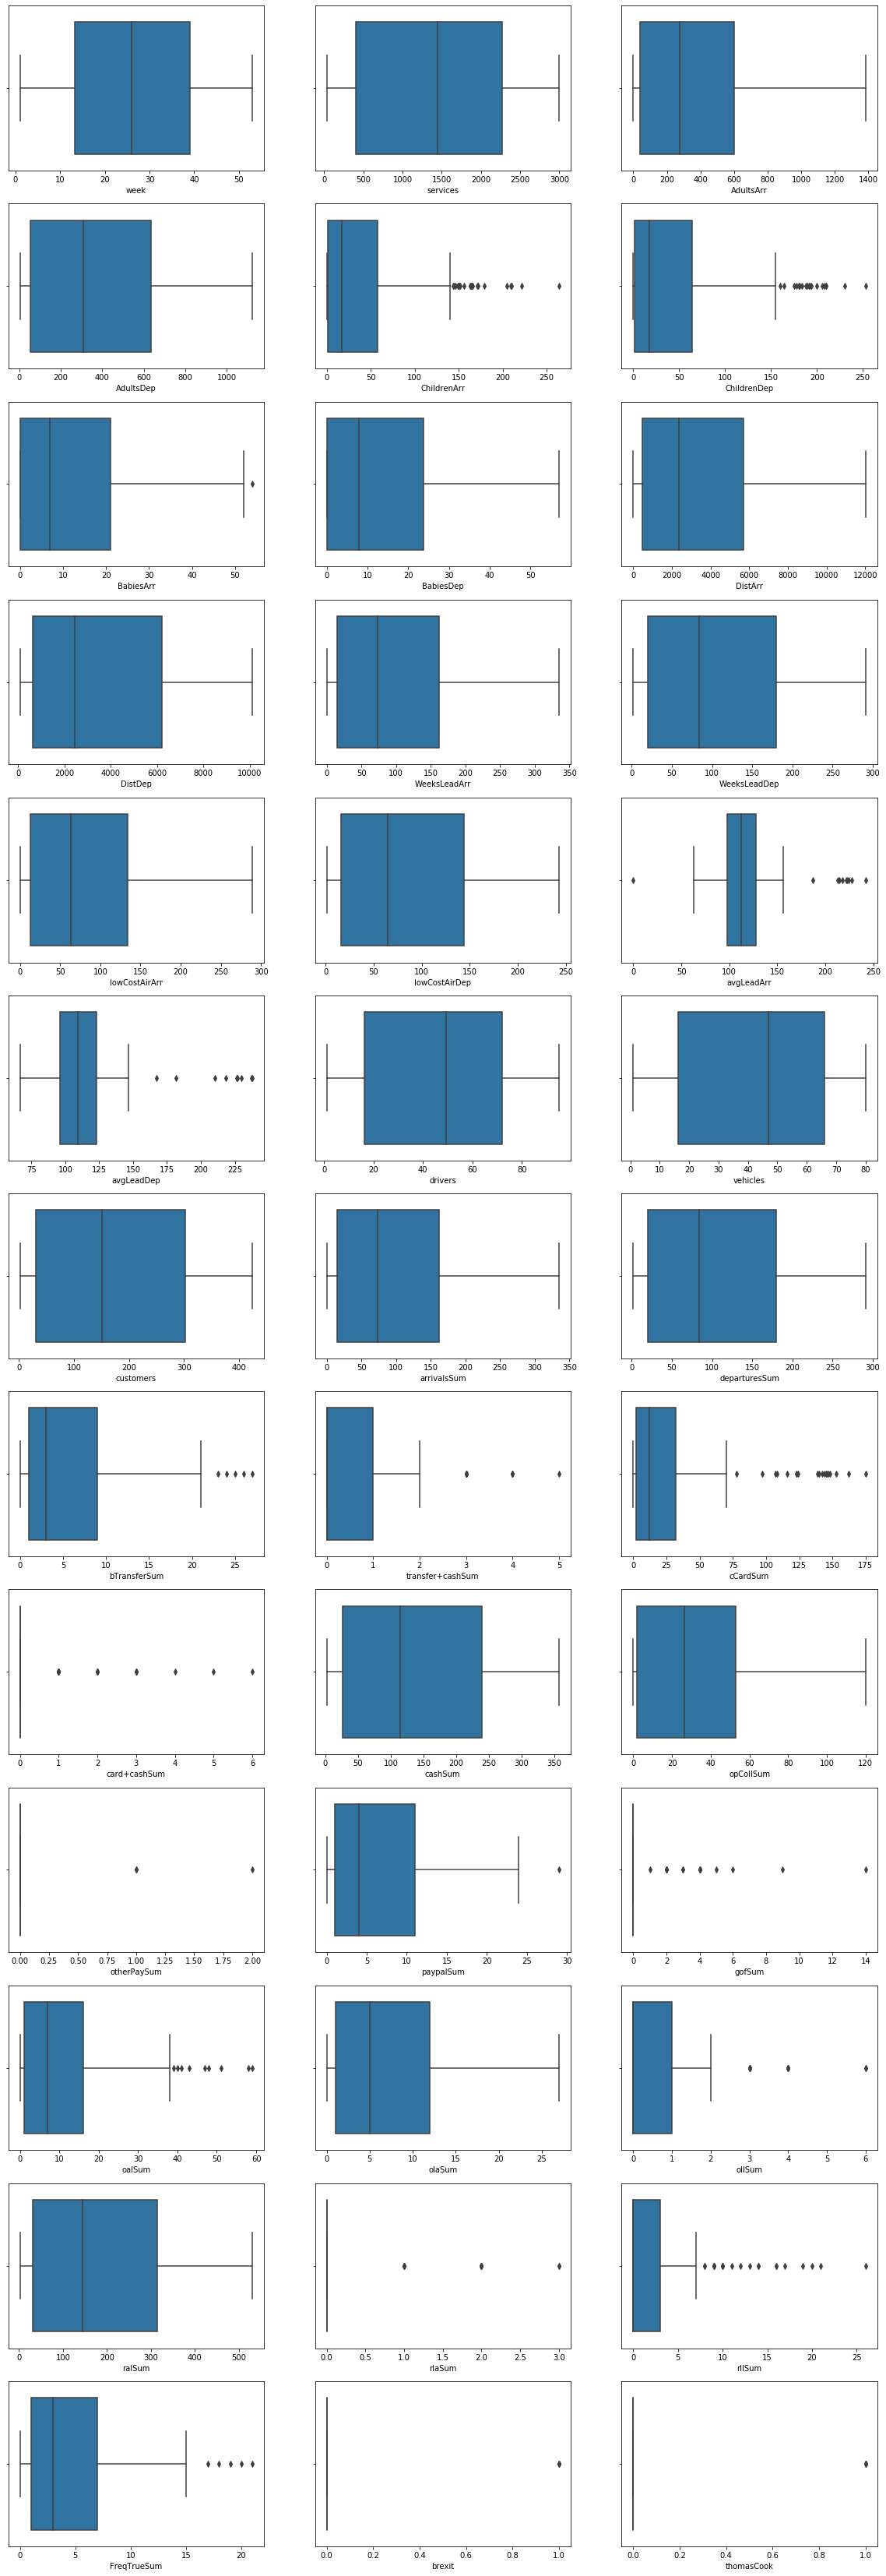

In [69]:
# Checking for outliers
# Boxplots on all numeric variables
numerical=modeling_df.select_dtypes(include=[np.number])
numerical = [col for col in numerical.columns]

plt_box(modeling_df[numerical])

In [71]:
# Checking the current columns
modeling_df.columns

Index(['year', 'week', 'services', 'AdultsArr', 'AdultsDep', 'ChildrenArr',
       'ChildrenDep', 'BabiesArr', 'BabiesDep', 'DistArr', 'DistDep',
       'WeeksLeadArr', 'WeeksLeadDep', 'lowCostAirArr', 'lowCostAirDep',
       'avgLeadArr', 'avgLeadDep', 'drivers', 'vehicles', 'customers',
       'arrivalsSum', 'departuresSum', 'bTransferSum', 'transfer+cashSum',
       'cCardSum', 'card+cashSum', 'cashSum', 'opCollSum', 'otherPaySum',
       'paypalSum', 'gofSum', 'oalSum', 'olaSum', 'ollSum', 'ralSum', 'rlaSum',
       'rllSum', 'FreqTrueSum', 'brexit', 'thomasCook'],
      dtype='object')

#### Finding outliers to remove

Due to the skewed distributions we are excluding variables related to the paymentType and serviceType from the IQR based outlier removal. Using the IQR, in these cases, leads to cutting a huge amount of data. Their variances (probably low) will whether they will be used or not in the model. If needed, manual outlier removal will be performed.

Also the binary variables should not be included in the outlier removal. Again, their variance will be later evaluated.

In [74]:
# Features to check for outliers
features = ['services', 'AdultsArr', 'AdultsDep', 'ChildrenArr', 'ChildrenDep', 'BabiesArr',
            'BabiesDep', 'DistArr', 'DistDep', 'WeeksLeadArr', 'WeeksLeadDep', 'avgLeadArr',
            'avgLeadDep', 'drivers', 'vehicles', 'customers', 'arrivalsSum', 'departuresSum',
            'FreqTrueSum']

# Selecting 3 IQR to remove the most extreme outliers
outliers_index = removeOutliers(modeling_df, 3, features)

services
Percentiles: 25th=406.500, 75th=2268.750, IQR=1862.250
Identified outliers: 0
AdultsArr
Percentiles: 25th=39.000, 75th=601.750, IQR=562.750
Identified outliers: 0
AdultsDep
Percentiles: 25th=52.750, 75th=634.250, IQR=581.500
Identified outliers: 0
ChildrenArr
Percentiles: 25th=1.250, 75th=57.750, IQR=56.500
Identified outliers: 1
ChildrenDep
Percentiles: 25th=1.250, 75th=64.250, IQR=63.000
Identified outliers: 0
BabiesArr
Percentiles: 25th=0.000, 75th=21.000, IQR=21.000
Identified outliers: 0
BabiesDep
Percentiles: 25th=0.000, 75th=23.750, IQR=23.750
Identified outliers: 0
DistArr
Percentiles: 25th=461.391, 75th=5700.789, IQR=5239.398
Identified outliers: 0
DistDep
Percentiles: 25th=621.584, 75th=6210.507, IQR=5588.923
Identified outliers: 0
WeeksLeadArr
Percentiles: 25th=15.000, 75th=161.750, IQR=146.750
Identified outliers: 0
WeeksLeadDep
Percentiles: 25th=20.000, 75th=180.000, IQR=160.000
Identified outliers: 0
avgLeadArr
Percentiles: 25th=97.629, 75th=128.196, IQR=30.567
I

In [73]:
modeling_df.head()

,year,week,services,AdultsArr,AdultsDep,ChildrenArr,ChildrenDep,BabiesArr,BabiesDep,DistArr,DistDep,WeeksLeadArr,WeeksLeadDep,lowCostAirArr,lowCostAirDep,avgLeadArr,avgLeadDep,drivers,vehicles,customers,arrivalsSum,departuresSum,bTransferSum,transfer+cashSum,cCardSum,card+cashSum,cashSum,opCollSum,otherPaySum,paypalSum,gofSum,oalSum,olaSum,ollSum,ralSum,rlaSum,rllSum,FreqTrueSum,brexit,thomasCook
0,2016,1,225,26.0,50.0,2.0,6.0,0.0,0.0,255.980103,422.959417,8.0,17.0,7.0,10.0,73.625000,100.176471,14,15,25,8.0,17.0,3.0,0.0,1.0,0.0,21.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,24.0,0.0,0.0,1.0,0,0
1,2016,10,304,32.0,79.0,0.0,0.0,0.0,0.0,341.352929,884.757699,12.0,32.0,8.0,25.0,88.583333,96.250000,19,23,41,12.0,32.0,4.0,0.0,1.0,0.0,34.0,2.0,0.0,3.0,0.0,1.0,1.0,0.0,42.0,0.0,0.0,0.0,0,0
2,2016,11,430,96.0,77.0,0.0,1.0,2.0,0.0,930.388217,904.653558,30.0,31.0,23.0,23.0,76.600000,78.838710,22,23,53,30.0,31.0,7.0,0.0,1.0,0.0,44.0,5.0,0.0,4.0,0.0,3.0,0.0,0.0,56.0,0.0,2.0,0.0,0,0
3,2016,12,754,131.0,95.0,22.0,0.0,6.0,2.0,1108.723988,1069.422297,42.0,38.0,35.0,28.0,84.809524,85.552632,25,26,70,42.0,38.0,9.0,0.0,3.0,0.0,54.0,9.0,0.0,5.0,0.0,1.0,1.0,0.0,78.0,0.0,0.0,3.0,0,0
4,2016,13,1072,189.0,234.0,40.0,27.0,8.0,7.0,1435.034400,1941.094078,53.0,73.0,39.0,56.0,99.622642,88.191781,35,34,102,53.0,73.0,12.0,0.0,9.0,0.0,81.0,16.0,0.0,8.0,0.0,3.0,1.0,0.0,118.0,0.0,4.0,2.0,0,0


In [75]:
# Variable to store the outlier's week and year
outlier_year_and_week = modeling_df.iloc[outliers_index].loc[:,['year','week']]

### Dropping features based on correlation

In [77]:
# Choosing the correlation thresold (among independent variables) to be 0.80 in order to avoid multicollinearity.
# In pairs with correlation higher than 0.80, we choose to maintain those with higher variance.
variables_ = list(modeling_df.columns)
indep_variables_ = list(modeling_df[variables_].columns)
indep_variables_.remove('services')
variances_ = modeling_df[indep_variables_].var().round(2).sort_values(ascending=False)

# Get the columns ordered by variance (to ensure that we remove the variable with less variance in each pair)
var_order = variances_.index.tolist()

# Temporary dataframe with re-ordered independent variables
df_ = modeling_df[var_order]

# Create correlation matrix
corr_matrix = df_.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.80
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
to_drop

# Drop these features
modeling_df.drop(to_drop, axis=1, inplace=True)
modeling_df.shape

(206, 16)

### Dropping features based on variance

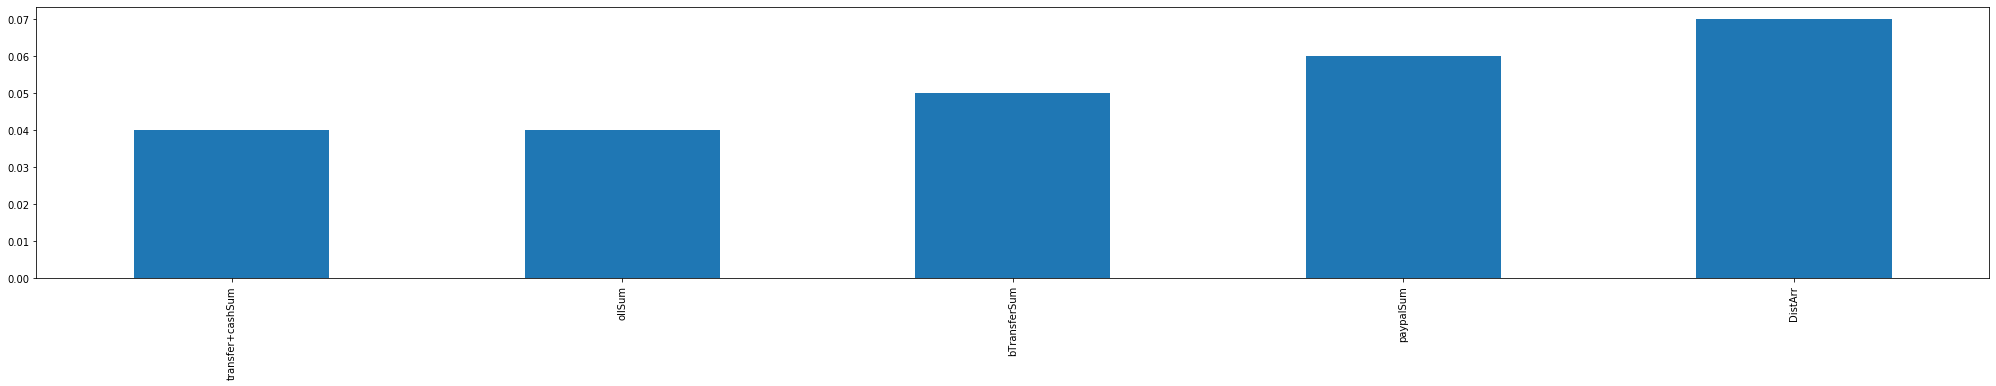

In [78]:
# Separating the variables
variables = list(modeling_df.columns)
indep_variables = list(modeling_df[variables].columns)
indep_variables.remove('services')
indep_variables.remove('week')
indep_variables.remove('year')

# Normalize all independent variables to check variance
X_array = modeling_df[indep_variables].values # returns a numpy array
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X_array)
modeling_df[indep_variables] = pd.DataFrame(X_scaled, columns=indep_variables)

# Checking the amount of variation of these features
variances = modeling_df[indep_variables].var().round(2)

# Features with (very) low variance should be dropped, we are setting threshold to 0.02
drop_var = variances[variances < 0.02].index.tolist()

#dropping these features
modeling_df.drop(columns=drop_var, inplace=True)

# Visualizing the last 5 feautures with lowest amount of variance per feature
variances.sort_values().tail(5).plot.bar(figsize=(35,5))

In [79]:
# Make the target variable be the last column
modeling_df = modeling_df[[c for c in modeling_df if c not in ['services']]+ ['services']]

In [80]:
# Again, separate the dependent and independent variables
variables = list(modeling_df.columns)
indep_variables = list(modeling_df[variables].columns)
indep_variables.remove('services')

<div class="alert alert-block alert-info">

These is the **final feature set** of modeling dataframe:

</div>

In [81]:
#final feature set
modeling_df.columns

Index(['year', 'week', 'DistArr', 'avgLeadArr', 'bTransferSum',
       'transfer+cashSum', 'card+cashSum', 'paypalSum', 'ollSum', 'rlaSum',
       'rllSum', 'brexit', 'thomasCook', 'services'],
      dtype='object')

# 5. Building the model

## 5.1. Splitting the data in training and test sets

X contains independent variables and y contains the target variable before scaling. We use as test set the weeks 20 and following of 2019. The train set will include weeks until 12 of 2019.

In [82]:
modeling_df['week'] = modeling_df['week'].astype(int)
modeling_df['year'] = modeling_df['year'].astype(int)
modeling_df.sort_values(by=['year','week'],inplace=True)
modeling_df.reset_index(drop=True,inplace=True)
X = modeling_df.drop(['services'], axis=1)
y = modeling_df['services']

In [85]:
X.tail(3)

,year,week,DistArr,avgLeadArr,bTransferSum,transfer+cashSum,card+cashSum,paypalSum,ollSum,rlaSum,rllSum,brexit,thomasCook
203,2019,47,0.008573,0.258953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204,2019,48,0.009900,0.266529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205,2019,49,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
#last 29 lines are weeks 20 to 49 of 2019
X_test = X[-30:]
y_test = y[-30:]

# Here we separate the training dataset to finish in week 12, i.e., to be cut 8 weeks before 
X_train = X[:-37]
y_train = y[:-37]

In [86]:
# X_test begins on week 20,2019
X_test.head(1)

,year,week,DistArr,avgLeadArr,bTransferSum,transfer+cashSum,card+cashSum,paypalSum,ollSum,rlaSum,rllSum,brexit,thomasCook
176,2019,20,0.818094,0.464502,0.296296,0.4,0.0,0.172414,0.0,0.0,0.807692,1.0,0.0


In [87]:
# X_train ends on week 12, 2019
X_train.tail(1)

,year,week,DistArr,avgLeadArr,bTransferSum,transfer+cashSum,card+cashSum,paypalSum,ollSum,rlaSum,rllSum,brexit,thomasCook
168,2019,12,0.097712,0.380047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
# Removing outliers (identified before) from the training set
for i, row in outlier_year_and_week.iterrows(): 
    indexNames = X_train[ (X_train['year'] == row["year"]) & (X_train['week'] == row["week"]) ].index
    X_train.drop(indexNames, inplace=True)
    y_train.drop(indexNames, inplace=True)

In [90]:
X_train.tail(3)

,year,week,DistArr,avgLeadArr,bTransferSum,transfer+cashSum,card+cashSum,paypalSum,ollSum,rlaSum,rllSum,brexit,thomasCook
166,2019,10,0.046600,0.411674,0.000000,0.0,0.0,0.068966,0.0,0.0,0.0,0.0,0.0
167,2019,11,0.072483,0.328168,0.037037,0.0,0.0,0.034483,0.0,0.0,0.0,0.0,0.0
168,2019,12,0.097712,0.380047,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [91]:
# Normalize all independent variables and create scaler based on train set. X_train = scaled training set
X_train_array = X_train.values # returns a numpy array
X_test_array = X_test.values

min_max_scaler_x = MinMaxScaler()

X_train_scaler = min_max_scaler_x.fit(X_train_array)

X_train_scaled = X_train_scaler.transform(X_train_array)
X_test_scaled = X_train_scaler.transform(X_test_array)

X_train_ = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_ = pd.DataFrame(X_test_scaled, columns=X.columns)

In [92]:
# Normalize the dependent variable (in order to use it in the GridSearch)
y_train_array = y_train.values # returns a numpy array
y_test_array = y_test.values

min_max_scaler_y = MinMaxScaler()

y_train_scaler = min_max_scaler_y.fit(y_train_array.reshape(-1, 1))

y_train_scaled = y_train_scaler.transform(y_train_array.reshape(-1, 1))
y_test_scaled = y_train_scaler.transform(y_test_array.reshape(-1, 1))

y_train_ = pd.Series([float(i) for i in y_train_scaled])
y_test_ = pd.Series([float(i) for i in y_test_scaled])

## 5.2. Setting the model

We are using Neural Networks from SciKitLearn and GridSearch CV for parameter optimization.

In [93]:
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
model = MLPRegressor()

Setting the parameter space to be tested with the model. Here many different combinations were tested and multiple iterations to find an optimal solution.
The combinations below are just a small sample.

In [94]:
parameter_space = {
    'hidden_layer_sizes': [(150,160,150),(150,150,150),(160,160,160)],
    'activation': ['relu'],
    'solver': ['sgd'],
    'learning_rate_init': [0.05,0.08,0.1,0.12,0.15],
    'learning_rate': ['adaptive'],
    'alpha': [0.0001, 0.0002, 0.0005, 0.001],
    'random_state': [150]
}

In [95]:
clf = GridSearchCV(model, parameter_space)

In [96]:
clf.fit(X_train_, y_train_)

GridSearchCV(cv=None, error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=200, momentum=0.9,
                                    n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_sta...
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['relu'],
                         'alpha': [0.0001, 0.0002, 0.0005, 0.001],
                         'hidden_layer_sizes': [(150, 160, 150),
                                                (150, 150, 150),
 

In [97]:
# Best parameter set found by GridSearch
clf.best_params_

{'activation': 'relu',
 'alpha': 0.0005,
 'hidden_layer_sizes': (150, 150, 150),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.15,
 'random_state': 150,
 'solver': 'sgd'}

In [98]:
model_best = MLPRegressor(activation = 'relu',
                          alpha = 0.0005,
                          hidden_layer_sizes = (150, 150, 150),
                          learning_rate = 'adaptive',
                          learning_rate_init = 0.15,
                          random_state = 150,
                          solver = 'sgd')

In [99]:
model_best.fit(X_train_, y_train_)

MLPRegressor(activation='relu', alpha=0.0005, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(150, 150, 150), learning_rate='adaptive',
             learning_rate_init=0.15, max_fun=15000, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=150, shuffle=True, solver='sgd', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [100]:
# predict y for X_train and X_test
y_pred_train = model_best.predict(X_train_) 
y_pred_test = model_best.predict(X_test_) 

## 5.3. Model evaluation

In [101]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train_, y_pred_train, y_test_, y_pred_test)
resultsDF

,Measure,Train,Test
0,MAE,0.043680,0.095232
1,RMSE,0.055102,0.115896
2,R^2,0.973460,0.908709
3,MAPE (%),inf,25.482222
4,MAX Error,0.145234,0.330327


In [102]:
# Visualize predictions vs close values 
y_test_ = y_test_.values
y_test_ = y_train_scaler.inverse_transform(y_test_.reshape(-1, 1))

temp = pd.Series([float(i) for i in y_test_]).to_frame()

temp['year'] = pd.Series([float(i) for i in X_test.year]).to_frame()
temp['week'] = pd.Series([float(i) for i in X_test.week]).to_frame()
temp['Predictions'] = y_train_scaler.inverse_transform(y_pred_test.reshape(-1, 1))
temp['Difference'] = [float(i) for i in y_test_] - temp.Predictions
temp['%Diff'] = ([float(i) for i in y_test_] - temp.Predictions)*100/[float(i) for i in y_test_]

In [103]:
temp[:8]

,0,year,week,Predictions,Difference,%Diff
0,2893.0,2019.0,20.0,2953.784511,-60.784511,-2.101089
1,2825.0,2019.0,21.0,2655.003577,169.996423,6.017572
2,2996.0,2019.0,22.0,2689.825489,306.174511,10.219443
3,2904.0,2019.0,23.0,2620.532469,283.467531,9.761279
4,2842.0,2019.0,24.0,3143.338474,-301.338474,-10.603043
5,2801.0,2019.0,25.0,3178.993533,-377.993533,-13.494949
6,2746.0,2019.0,26.0,2952.268796,-206.268796,-7.511609
7,2805.0,2019.0,27.0,3255.847114,-450.847114,-16.072981


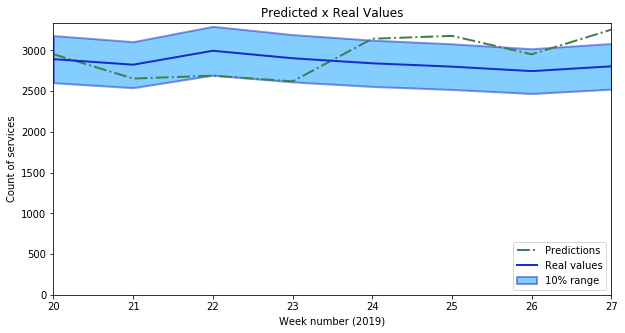

In [104]:
x = temp['week'][:8]
predictions = temp['Predictions'][:8]
real_values = temp[0][:8]
diff = temp['%Diff'][:8]
error = abs(temp['Difference'][:8])/2

plt.figure(figsize=(10,5))
plt.plot(x, predictions, 'k', linewidth=2, linestyle='dashdot', color='#3F7F4C', label = 'Predictions')
plt.plot(x, real_values, 'k', linewidth=2, color='#1B2ACC', label = 'Real values')
plt.fill_between(x, real_values*0.9, real_values*1.1,
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=2, antialiased=True, label = '10% range')

plt.xlim(xmin=20,xmax=27)
plt.ylim(ymin=0)
plt.title("Predicted x Real Values")
plt.xlabel("Week number (2019)")
plt.ylabel("Count of services")
plt.legend(loc="lower right")

plt.show()

In [105]:
print('Mean absolute %Diff for the 4 predicted weeks: ', round(np.mean(abs(temp[:4]['%Diff'])),2), ' %')

Mean absolute %Diff for the 4 predicted weeks:  7.02  %


<div class="alert alert-block alert-info">

As we can see, our predictions for the first four predicted weeks are within a 10% range from our real values
as requested from our client (**7%**). And as would be expected, the further away in time the preditions are made, the more inaccurate they are.

We can also confirm that the model will not be completely unrealistic, even when we go past the expected predictions of four weeks.

Following we will show that if we take a bigger training set, to predict even further in the future, this model will still be able to preform accurate predictions.

</div>

## 5.4. Model evaluation (Extra - starting on week 28)

We also used the same model fitting pattern with another 4 training data slices (weeks until 20 to 23) to predict services in weeks 28 to 31.

In [115]:
X.tail(3)

,year,week,DistArr,avgLeadArr,bTransferSum,transfer+cashSum,card+cashSum,paypalSum,ollSum,rlaSum,rllSum,brexit,thomasCook
203,2019,47,0.008573,0.258953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204,2019,48,0.009900,0.266529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205,2019,49,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
#last 22 lines are weeks 28-49, 2019
X_test = [X[-22:],X[-21:],X[-20:],X[-19:],X[-18:],
          X[-17:],X[-16:],X[-15:],X[-14:]]
y_test = [y[-22:],y[-21:],y[-20:],y[-19:],y[-18:],
          y[-17:],y[-16:],y[-15:],y[-14:]]

# Here we separate the training dataset to be cut 8 weeks before 
X_train = [X[-30:],X[-29:],X[-28:],X[-27:],X[-26:],
          X[-25:],X[-24:],X[-23:],X[-22:]]
y_train = [y[-30:],y[-29:],y[-28:],y[-27:],y[-26:],
          y[-25:],y[-24:],y[-23:],y[-22:]]

In [108]:
# Removing outliers (identified before) from the training set
for j in range(9):
    for i, row in outlier_year_and_week.iterrows(): 
        indexNames = X_train[j][(X_train[j]['year'] == row["year"]) & (X_train[j]['week'] == row["week"])].index
        X_train[j].drop(indexNames, inplace=True)
        y_train[j].drop(indexNames, inplace=True)

In [109]:
# Normalize all independent variables and create scaler based on train set. X_train = scaled training set
X_train_ = []
X_test_ = []

for i in range(9):
    X_train_array = X_train[i].values # returns a numpy array
    X_test_array = X_test[i].values

    min_max_scaler_x = MinMaxScaler()

    X_train_scaler = min_max_scaler_x.fit(X_train_array)

    X_train_scaled = X_train_scaler.transform(X_train_array)
    X_test_scaled = X_train_scaler.transform(X_test_array)

    X_train_.insert(i, pd.DataFrame(X_train_scaled, columns=X.columns))
    X_test_.insert(i,pd.DataFrame(X_test_scaled, columns=X.columns))

In [110]:
# Normalize the dependent variable
y_train_ = []
y_test_ = []

for i in range(9):
    y_train_array = y_train[i].values # returns a numpy array
    y_test_array = y_test[i].values

    min_max_scaler_y = MinMaxScaler()

    y_train_scaler = min_max_scaler_y.fit(y_train_array.reshape(-1, 1))

    y_train_scaled = y_train_scaler.transform(y_train_array.reshape(-1, 1))
    y_test_scaled = y_train_scaler.transform(y_test_array.reshape(-1, 1))

    y_train_.insert(i,pd.Series([float(i) for i in y_train_scaled]))
    y_test_.insert(i,pd.Series([float(i) for i in y_test_scaled]))

In [111]:
clf = GridSearchCV(model, parameter_space)

In [112]:
clf.fit(X_train_[0], y_train_[0])

GridSearchCV(cv=None, error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=200, momentum=0.9,
                                    n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_sta...
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['relu'],
                         'alpha': [0.0001, 0.0002, 0.0005, 0.001],
                         'hidden_layer_sizes': [(150, 160, 150),
                                                (150, 150, 150),
 

In [113]:
clf.best_params_

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (150, 150, 150),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.12,
 'random_state': 150,
 'solver': 'sgd'}

In [114]:
model_best = MLPRegressor(activation = 'relu',
                          alpha = 0.0005,
                          hidden_layer_sizes = (150, 150, 150),
                          learning_rate = 'adaptive',
                          learning_rate_init = 0.05,
                          random_state = 150,
                          solver = 'sgd')

For simplicity, we are only fitting the model to the first training period and applying it to all training samples, despite it can assume new parameters and be fitted again for each prediction batch.

In [116]:
model_best.fit(X_train_[0], y_train_[0])

MLPRegressor(activation='relu', alpha=0.0005, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(150, 150, 150), learning_rate='adaptive',
             learning_rate_init=0.05, max_fun=15000, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=150, shuffle=True, solver='sgd', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [117]:
# predict y for X_train and X_test
y_pred_train = model_best.predict(X_train_[0]) 
y_pred_test = model_best.predict(X_test_[0]) 

In [118]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train_[0], y_pred_train, y_test_[0], y_pred_test)
resultsDF

,Measure,Train,Test
0,MAE,0.049440,0.061007
1,RMSE,0.066604,0.076500
2,R^2,0.959749,0.945295
3,MAPE (%),inf,inf
4,MAX Error,0.160589,0.160589


In [119]:
batches_diff_8weeks = pd.DataFrame()

for i in range (9):
    model_best.fit(X_train_[i], y_train_[i])
    
    # predict y for X_train and X_test
    y_pred_train = model_best.predict(X_train_[i]) 
    y_pred_test = model_best.predict(X_test_[i])
    
    # Show performance results
    resultsDF = performanceMetricsDF(metrics, y_train_[i], y_pred_train, y_test_[i], y_pred_test)
    resultsDF
    
    y_test2 = y_test_[i].values
    y_test2 = y_train_scaler.inverse_transform(y_test2.reshape(-1, 1))

    temp = pd.Series([float(i) for i in y_test2]).to_frame()
    temp['year'] = pd.Series([float(i) for i in X_test[i].year]).to_frame()
    temp['week'] = pd.Series([float(i) for i in X_test[i].week]).to_frame()
    temp['Predictions'] = y_train_scaler.inverse_transform(y_pred_test.reshape(-1, 1))
    temp['Difference'] = [float(i) for i in y_test2] - temp.Predictions
    temp['%Diff'] = ([float(i) for i in y_test2] - temp.Predictions)*100/[float(i) for i in y_test2]
        
    batches_diff_8weeks[X_test[i]['week'].iloc[0]] = temp['%Diff'][:4]
    print('Predicting week', X_test[i]['week'].iloc[0],'and later with data until week', X_train[i]['week'].iloc[0], '\n')
    print('Mean absolute %Diff for the 4 predicted weeks: ', round(np.mean(abs(temp[:4]['%Diff'])),2), ' %', '\n')
    print(temp[:4], '\n')

Predicting week 28 and later with data until week 20 

Mean absolute %Diff for the 4 predicted weeks:  1.17  % 

             0    year  week  Predictions  Difference     %Diff
0  2775.125421  2019.0  28.0  2685.984593   89.140829  3.212137
1  2799.349966  2019.0  29.0  2801.682955   -2.332988 -0.083340
2  2735.397168  2019.0  30.0  2745.275436   -9.878268 -0.361127
3  2663.692515  2019.0  31.0  2691.095539  -27.403024 -1.028761 

Predicting week 29 and later with data until week 21 

Mean absolute %Diff for the 4 predicted weeks:  1.64  % 

             0    year  week  Predictions  Difference     %Diff
0  2799.349966  2019.0  29.0  2795.969553    3.380413  0.120757
1  2735.397168  2019.0  30.0  2744.559774   -9.162606 -0.334964
2  2663.692515  2019.0  31.0  2703.853534  -40.161019 -1.507720
3  2628.809171  2019.0  32.0  2749.226938 -120.417768 -4.580696 

Predicting week 30 and later with data until week 22 

Mean absolute %Diff for the 4 predicted weeks:  4.61  % 

             0   

In [120]:
batches_diff_8weeks

,28,29,30,31,32,33,34,35,36
0,3.212137,0.120757,-0.050455,-1.907513,-2.221453,-12.412904,1.970416,0.814039,6.354922
1,-0.083340,-0.334964,-1.577266,-3.912976,-12.033067,2.179354,5.861697,5.955719,-22.048335
2,-0.361127,-1.507720,-4.100929,-11.982476,2.892182,5.668965,11.619303,-23.067944,-10.480709
3,-1.028761,-4.580696,-12.703025,3.572538,6.388795,11.853704,-23.656054,-11.205889,16.076586


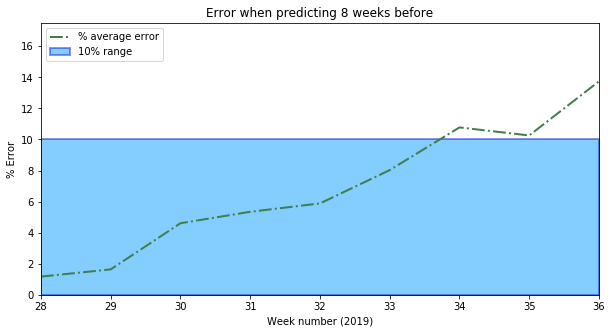

In [121]:
x = batches_diff_8weeks.columns
y = batches_diff_8weeks.apply(abs).apply(np.mean,axis=0)

plt.figure(figsize=(10,5))
plt.plot(x, y, 'k', linewidth=2, linestyle='dashdot', color='#3F7F4C', label = '% average error')
#plt.plot(x, real_values, 'k', linewidth=2, color='#1B2ACC', label = 'Real values')
plt.fill_between(x, 0, 10,
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=2, antialiased=True, label = '10% range')

plt.xlim(xmin=28,xmax=36)
plt.ylim(ymin=0,ymax=17.5)
plt.title("Error when predicting 8 weeks before")
plt.xlabel("Week number (2019)")
plt.ylabel("% Error")
plt.legend(loc="upper left")

plt.show()

We can see that even when we predict further into the future, this model is still viable.
The big deviation in week 36 is caused by the bankruptcy of the Thomas Cook company, which is a very dificult event to predict just based on the provided dataset.

## Concluding comments

<div class="alert alert-block alert-info">

Overall, this model is expected to answer the needs of the client with an mean absolute error of 7% for the the first four week batch (clearly under the target of 10% requested).

Some data quality issues were discovered and therefore should be addressed when implementing this model.

Concerning deployment and maintenence of this project, here are our recommendations:
* Re-run model every four weeks (minimum) and automate it;
* Connect model directly to company database (right now model runs on limited historical data);

Some improvements could still be made, especially when taken into consideration the effects of events similar to the Thomas Cook bankruptcy that skewed our results as seen above.

The company can also consider the following improvments for better predictions and 
* Adding Google Maps API to better measure trips distance and duration is expected to improve model;
* Consider offering joint trips in situations where clients have similar trips;
* Consider running the model 4 weeks before target also, since we have seen that this will dramatically increase accuracy;
 
</div>